In [1]:
from sklearn.linear_model import LogisticRegression
import torch
import pickle
import torch.nn as nn
from tqdm import tqdm
from utils import float32_to_int16, int16_to_float32
from einops import rearrange #might need to do pip install einops
import warnings
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read in pickle data
with open('activations_1.pkl', 'rb') as f:
    df1 = pickle.load(f)
with open('activations_2.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [3]:

all_xs = []     # shape: (batch_size, num_layers, k, model_dim)
for df in [df1, df2]:
    for i in range(len(df)):
        all_layers = []
        for layer in range(1,13):
            all_layers.append(int16_to_float32(df[i][f'hidden_{layer}'][0]))
        all_xs.append(torch.stack(all_layers).to(DEVICE).to(torch.float32))
all_xs = torch.stack(all_xs).to(DEVICE).to(torch.float32)

train_split = int(.8 * len(all_xs))
x_train = all_xs[:train_split]
x_test = all_xs[train_split:]


In [265]:
class Probe(nn.Module):
    def __init__(self):
        super().__init__()
        self.probe = nn.Linear(768,1, bias=True).to(torch.float32)
    def forward(self, x):
        return torch.sigmoid(self.probe(x))
    def complement(self):
        p = Probe()
        p.probe.weight.data = -self.probe.weight.data
        p.probe.bias.data = -self.probe.bias.data
        return p
    
def ccs_loss(pair, probe):
    probs = probe(pair).squeeze(dim=-1)
    l_const = (1 - probs.sum(dim=-1))**2
    l_conf = (probs.min(dim=-1).values)**2
    return (l_const + l_conf).mean()

def gabe_loss(pair, probe):
    probs = probe(pair).squeeze(dim=-1)
    l_first = probs.min(dim=-1).values**2
    l_second = (1-probs.max(dim=-1).values)**2
    return (l_first + l_second).mean()

def probe_acc(data, probe):
    with torch.no_grad():
        probs = probe(data).squeeze(dim=-1)
        correct = (probs.max(dim=-1).indices == 0).sum().item()
    return correct/len(data)

In [122]:
# do logistic regression with scikit-learn
lr = LogisticRegression(max_iter=1000)
lr_accs = {}
lr_probes = {}

num_classes = 2
import warnings
for layer in range(1,13):
    xs_lr = rearrange(x_train[:, layer-1, :num_classes], 'b k d -> (b k) d').to("cpu")
    ys_lr = torch.tensor(([1] + [0]*(num_classes-1)) * len(x_train)).to("cpu")

    # train logistic regression, witholding warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lr.fit(xs_lr, ys_lr)

    p_lr = Probe()
    p_lr.probe.weight = nn.Parameter(torch.tensor(lr.coef_).to(DEVICE).to(torch.float32))
    p_lr.probe.bias = nn.Parameter(torch.tensor(lr.intercept_).to(DEVICE).to(torch.float32))
    
    lr_probes[layer] = p_lr
    xs_lr_test = x_test[:, layer-1, :num_classes]
    lr_accs[layer] = probe_acc(xs_lr_test, p_lr)

    assert torch.allclose(
        rearrange(p_lr(xs_lr_test).squeeze(dim=-1), "a b -> (a b)"),
        torch.tensor(lr.predict_proba(rearrange(xs_lr_test, "b k d -> (b k) d").cpu())[:, 1], device=DEVICE, dtype=torch.float32))
    print(f"Trained layer {layer}, {lr_accs[layer]}")
    # accs[layer] = ((lr_outputs[0::4] > lr_outputs[1::4]) & (lr_outputs[0::4] > lr_outputs[2::4]) & (lr_outputs[0::4] > lr_outputs[3::4])).mean()




Trained layer 1, 0.4975
Trained layer 2, 0.5075
Trained layer 3, 0.51
Trained layer 4, 0.5425
Trained layer 5, 0.5425
Trained layer 6, 0.5875
Trained layer 7, 0.59
Trained layer 8, 0.5875
Trained layer 9, 0.5875
Trained layer 10, 0.62
Trained layer 11, 0.6575
Trained layer 12, 0.69


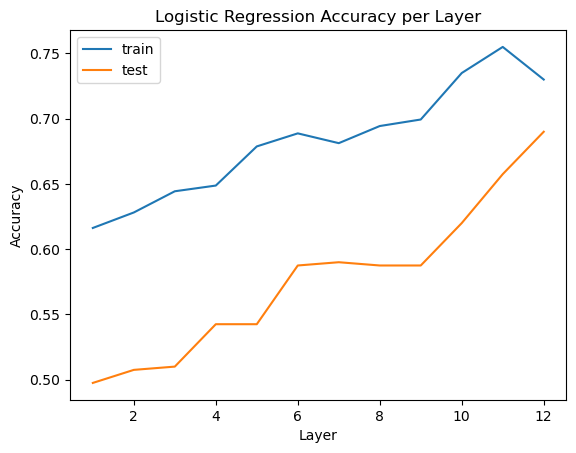

In [147]:
# plot lr_acc per layer

lr_train_accs = [probe_acc(x_train[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
lr_test_accs = [probe_acc(x_test[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
indices = np.arange(1,13)

plt.plot(indices, lr_train_accs, label='train')
plt.plot(indices, lr_test_accs, label='test')
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy per Layer")
plt.show()


In [159]:

epochs = 30000
num_attempts = 3

ccs_probes = {}
ccs_losses = {}
ccs_loss_history = {}

for layer in range(1,13):
    for attempt in range(num_attempts):
        p = Probe().to(DEVICE)
        optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
        for i in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = ccs_loss(x_train[:, layer-1, :num_classes], p)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                ccs_loss_history[(layer, attempt, i)] = loss.item()

        if probe_acc(x_test[:, layer-1, :num_classes], p) < 0.5:
            p = p.complement()
        # save probe if lowest loss so far
        if layer not in ccs_losses or loss < ccs_losses[layer]:
            ccs_losses[layer] = loss
            ccs_probes[layer] = p
            print(f'ccs layer {layer} attempt {attempt} loss {loss}')

gabe_probes = {}
gabe_losses = {}
gabe_loss_history = {}

for layer in range(1,13):
    for attempt in range(num_attempts):
        p = Probe().to(DEVICE)
        optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
        for i in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = gabe_loss(x_train[:, layer-1, :num_classes], p)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                gabe_loss_history[(layer, attempt, i)] = loss.item()

        if probe_acc(x_test[:, layer-1, :num_classes], p) < 0.5:
            p = p.complement()
        # save probe if lowest loss so far
        if layer not in gabe_losses or loss < gabe_losses[layer]:
            gabe_losses[layer] = loss
            gabe_probes[layer] = p
            print(f'gabe layer {layer} attempt {attempt} loss {loss}')





100%|██████████| 30000/30000 [00:39<00:00, 756.09it/s]


ccs layer 1 attempt 0 loss 0.1929779350757599


100%|██████████| 30000/30000 [00:39<00:00, 751.47it/s]


ccs layer 1 attempt 2 loss 0.1929098516702652


100%|██████████| 30000/30000 [00:39<00:00, 752.55it/s]


ccs layer 2 attempt 0 loss 0.17606723308563232


100%|██████████| 30000/30000 [00:39<00:00, 753.74it/s]


ccs layer 2 attempt 1 loss 0.17348381876945496


100%|██████████| 30000/30000 [00:39<00:00, 754.43it/s]


ccs layer 2 attempt 2 loss 0.17274844646453857


100%|██████████| 30000/30000 [00:39<00:00, 758.81it/s]


ccs layer 3 attempt 0 loss 0.16944703459739685


100%|██████████| 30000/30000 [00:39<00:00, 754.45it/s]


ccs layer 4 attempt 0 loss 0.1641153246164322


100%|██████████| 30000/30000 [00:39<00:00, 755.04it/s]


ccs layer 5 attempt 0 loss 0.1659262478351593


100%|██████████| 30000/30000 [00:39<00:00, 757.58it/s]


ccs layer 5 attempt 2 loss 0.16576291620731354


100%|██████████| 30000/30000 [00:39<00:00, 756.84it/s]


ccs layer 6 attempt 0 loss 0.1652492880821228


100%|██████████| 30000/30000 [00:39<00:00, 757.89it/s]


ccs layer 7 attempt 0 loss 0.16744990646839142


100%|██████████| 30000/30000 [00:39<00:00, 765.61it/s]


ccs layer 7 attempt 2 loss 0.16329962015151978


100%|██████████| 30000/30000 [00:38<00:00, 771.22it/s]


ccs layer 8 attempt 0 loss 0.23336604237556458


100%|██████████| 30000/30000 [00:39<00:00, 768.39it/s]


ccs layer 8 attempt 1 loss 0.1869097352027893


100%|██████████| 30000/30000 [00:39<00:00, 768.77it/s]


ccs layer 8 attempt 2 loss 0.18641597032546997


100%|██████████| 30000/30000 [00:39<00:00, 767.67it/s]


ccs layer 9 attempt 0 loss 0.35596412420272827


100%|██████████| 30000/30000 [00:39<00:00, 765.97it/s]


ccs layer 9 attempt 1 loss 0.22345538437366486


100%|██████████| 30000/30000 [00:39<00:00, 766.05it/s]


ccs layer 10 attempt 0 loss 0.4172067940235138


100%|██████████| 30000/30000 [00:39<00:00, 767.24it/s]


ccs layer 10 attempt 1 loss 0.28644609451293945


100%|██████████| 30000/30000 [00:38<00:00, 769.79it/s]


ccs layer 11 attempt 0 loss 0.27216440439224243


100%|██████████| 30000/30000 [00:39<00:00, 768.57it/s]


ccs layer 11 attempt 1 loss 0.22873562574386597


100%|██████████| 30000/30000 [00:38<00:00, 769.47it/s]


ccs layer 12 attempt 0 loss 0.16068494319915771


100%|██████████| 30000/30000 [00:39<00:00, 764.31it/s]


ccs layer 12 attempt 2 loss 0.15979298949241638


100%|██████████| 30000/30000 [00:40<00:00, 745.52it/s]


gabe layer 1 attempt 0 loss 0.4529973566532135


100%|██████████| 30000/30000 [00:39<00:00, 750.72it/s]


gabe layer 1 attempt 1 loss 0.4426599442958832


100%|██████████| 30000/30000 [00:40<00:00, 740.70it/s]


gabe layer 2 attempt 0 loss 0.3336730897426605


100%|██████████| 30000/30000 [00:40<00:00, 743.74it/s]


gabe layer 2 attempt 1 loss 0.3108721077442169


100%|██████████| 30000/30000 [00:39<00:00, 753.21it/s]


gabe layer 2 attempt 2 loss 0.3094452917575836


100%|██████████| 30000/30000 [00:40<00:00, 746.09it/s]


gabe layer 3 attempt 0 loss 0.295138418674469


100%|██████████| 30000/30000 [00:40<00:00, 747.15it/s]


gabe layer 3 attempt 1 loss 0.24334998428821564


100%|██████████| 30000/30000 [00:40<00:00, 748.91it/s]


gabe layer 4 attempt 0 loss 0.24414792656898499


100%|██████████| 30000/30000 [00:40<00:00, 748.52it/s]


gabe layer 4 attempt 2 loss 0.21266674995422363


100%|██████████| 30000/30000 [00:41<00:00, 731.47it/s]


gabe layer 5 attempt 0 loss 0.23341815173625946


100%|██████████| 30000/30000 [00:40<00:00, 744.93it/s]


gabe layer 5 attempt 2 loss 0.2098197489976883


100%|██████████| 30000/30000 [00:40<00:00, 747.70it/s]


gabe layer 6 attempt 0 loss 0.24290506541728973


100%|██████████| 30000/30000 [00:40<00:00, 748.19it/s]


gabe layer 6 attempt 1 loss 0.2288585603237152


100%|██████████| 30000/30000 [00:40<00:00, 738.38it/s]


gabe layer 7 attempt 0 loss 0.25682345032691956


100%|██████████| 30000/30000 [00:40<00:00, 741.89it/s]


gabe layer 7 attempt 1 loss 0.25287675857543945


100%|██████████| 30000/30000 [00:39<00:00, 750.57it/s]


gabe layer 8 attempt 0 loss 0.253860205411911


100%|██████████| 30000/30000 [00:40<00:00, 746.80it/s]


gabe layer 9 attempt 0 loss 0.5186366438865662


100%|██████████| 30000/30000 [00:39<00:00, 753.77it/s]


gabe layer 9 attempt 1 loss 0.2253309190273285


100%|██████████| 30000/30000 [00:39<00:00, 753.96it/s]


gabe layer 10 attempt 0 loss 0.37192419171333313


100%|██████████| 30000/30000 [00:40<00:00, 746.36it/s]


gabe layer 10 attempt 1 loss 0.30635568499565125


100%|██████████| 30000/30000 [00:39<00:00, 755.09it/s]


gabe layer 10 attempt 2 loss 0.2587404251098633


100%|██████████| 30000/30000 [00:40<00:00, 749.42it/s]


gabe layer 11 attempt 0 loss 0.39361876249313354


100%|██████████| 30000/30000 [00:40<00:00, 742.13it/s]


gabe layer 11 attempt 2 loss 0.32522159814834595


100%|██████████| 30000/30000 [00:39<00:00, 751.78it/s]


gabe layer 12 attempt 0 loss 0.29734379053115845


100%|██████████| 30000/30000 [00:40<00:00, 749.90it/s]


gabe layer 12 attempt 1 loss 0.29688337445259094


100%|██████████| 30000/30000 [00:40<00:00, 737.94it/s]


In [160]:
gabe_losses

{1: tensor(0.4427, device='cuda:0', grad_fn=<MeanBackward0>),
 2: tensor(0.3094, device='cuda:0', grad_fn=<MeanBackward0>),
 3: tensor(0.2433, device='cuda:0', grad_fn=<MeanBackward0>),
 4: tensor(0.2127, device='cuda:0', grad_fn=<MeanBackward0>),
 5: tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>),
 6: tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>),
 7: tensor(0.2529, device='cuda:0', grad_fn=<MeanBackward0>),
 8: tensor(0.2539, device='cuda:0', grad_fn=<MeanBackward0>),
 9: tensor(0.2253, device='cuda:0', grad_fn=<MeanBackward0>),
 10: tensor(0.2587, device='cuda:0', grad_fn=<MeanBackward0>),
 11: tensor(0.3252, device='cuda:0', grad_fn=<MeanBackward0>),
 12: tensor(0.2969, device='cuda:0', grad_fn=<MeanBackward0>)}

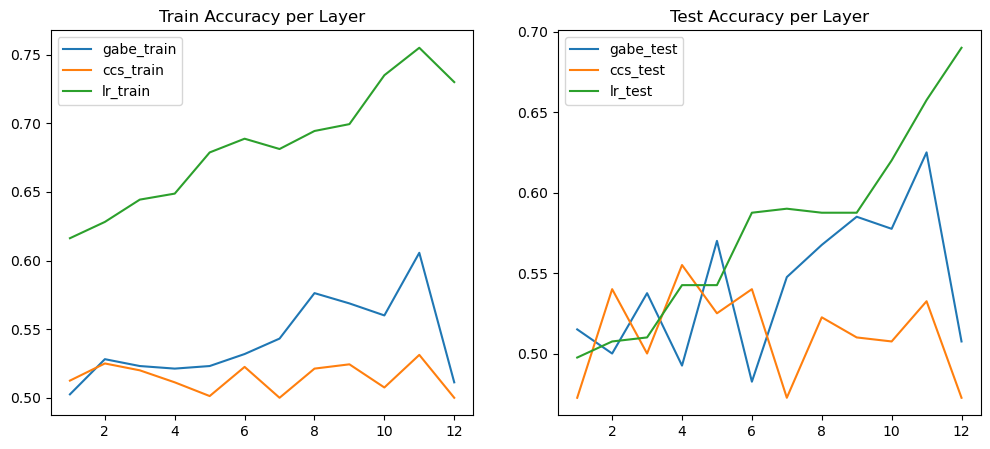

In [177]:
# plot gabe_acc per layer


gabe_train_accs = [probe_acc(x_train[:,i-1,:num_classes], gabe_probes[i]) for i in range(1,13)]
gabe_test_accs = [probe_acc(x_test[:,i-1,:num_classes], gabe_probes[i]) for i in range(1,13)]
gabe_flip = [x < .5 for x in gabe_train_accs]
gabe_train_accs = [1-x if gabe_flip[i] else x for i,x in enumerate(gabe_train_accs)]
gabe_test_accs = [1-x if gabe_flip[i] else x for i,x in enumerate(gabe_test_accs)]

ccs_train_accs = [probe_acc(x_train[:,i-1,:num_classes], ccs_probes[i]) for i in range(1,13)]
ccs_test_accs = [probe_acc(x_test[:,i-1,:num_classes], ccs_probes[i]) for i in range(1,13)]
ccs_flip = [x < .5 for x in ccs_train_accs]
ccs_train_accs = [1-x if ccs_flip[i] else x for i,x in enumerate(ccs_train_accs)]
ccs_test_accs = [1-x if ccs_flip[i] else x for i,x in enumerate(ccs_test_accs)]

lr_train_accs = [probe_acc(x_train[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
lr_test_accs = [probe_acc(x_test[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]

indices = np.arange(1,13)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(indices, gabe_train_accs, label='gabe_train')
plt.plot(indices, ccs_train_accs, label='ccs_train')
plt.plot(indices, lr_train_accs, label='lr_train')
plt.legend()
plt.title("Train Accuracy per Layer")
plt.subplot(1,2,2)
plt.plot(indices, gabe_test_accs, label='gabe_test')
plt.plot(indices, ccs_test_accs, label='ccs_test')
plt.plot(indices, lr_test_accs, label='lr_test')
plt.legend()
plt.title("Test Accuracy per Layer")
plt.show()


In [149]:
save = (gabe_probes, gabe_losses)

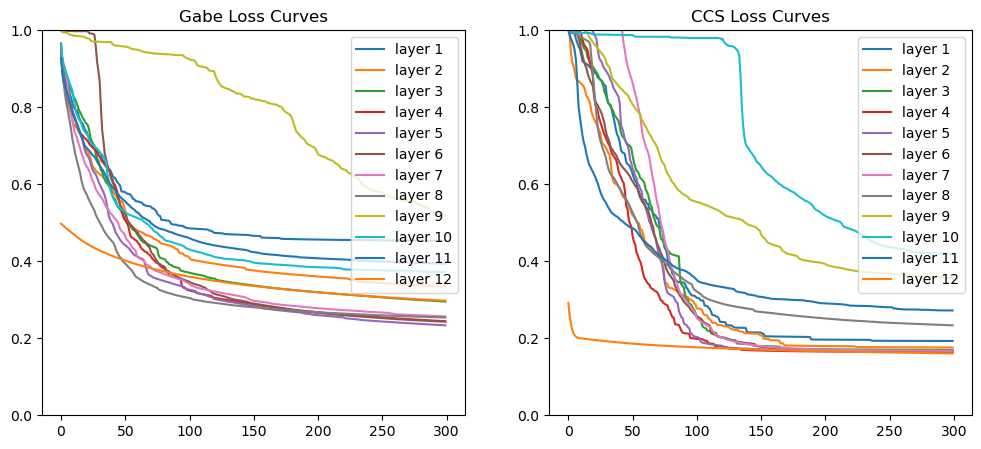

In [183]:
#Plot loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for layer in range(1,13):
    for attempt in range(1):
        plt.plot([gabe_loss_history[(layer, attempt, i)] for i in range(0,epochs,100)], label=f'layer {layer}')
plt.legend()
# make y scale [0, 1]
plt.ylim(0,1)
plt.title("Gabe Loss Curves")
plt.subplot(1,2,2)
for layer in range(1,13):
    plt.plot([ccs_loss_history[(layer, attempt, i)] for i in range(0,epochs,100)], label=f'layer {layer}')
plt.ylim(0,1)
plt.legend()
plt.title("CCS Loss Curves")
plt.show()


Text(0.5, 1.0, 'Train Accuracy vs Loss')

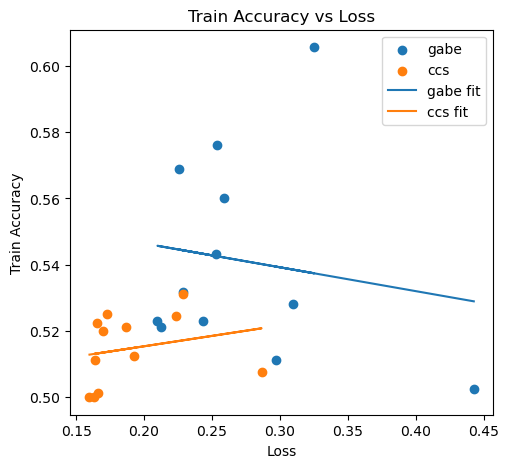

In [190]:
# plot loss vs train accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter([gabe_losses[i].item() for i in range(1,13)], gabe_train_accs, label='gabe')
plt.scatter([ccs_losses[i].item() for i in range(1,13)], ccs_train_accs, label='ccs')

#add lines of best fit
m, b = np.polyfit([gabe_losses[i].item() for i in range(1,13)], gabe_train_accs, 1)
plt.plot([gabe_losses[i].item() for i in range(1,13)], [m*x + b for x in [gabe_losses[i].item() for i in range(1,13)]], label='gabe fit')
m, b = np.polyfit([ccs_losses[i].item() for i in range(1,13)], ccs_train_accs, 1)
plt.plot([ccs_losses[i].item() for i in range(1,13)], [m*x + b for x in [ccs_losses[i].item() for i in range(1,13)]], label='ccs fit')


plt.legend()
plt.xlabel("Loss")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Loss")

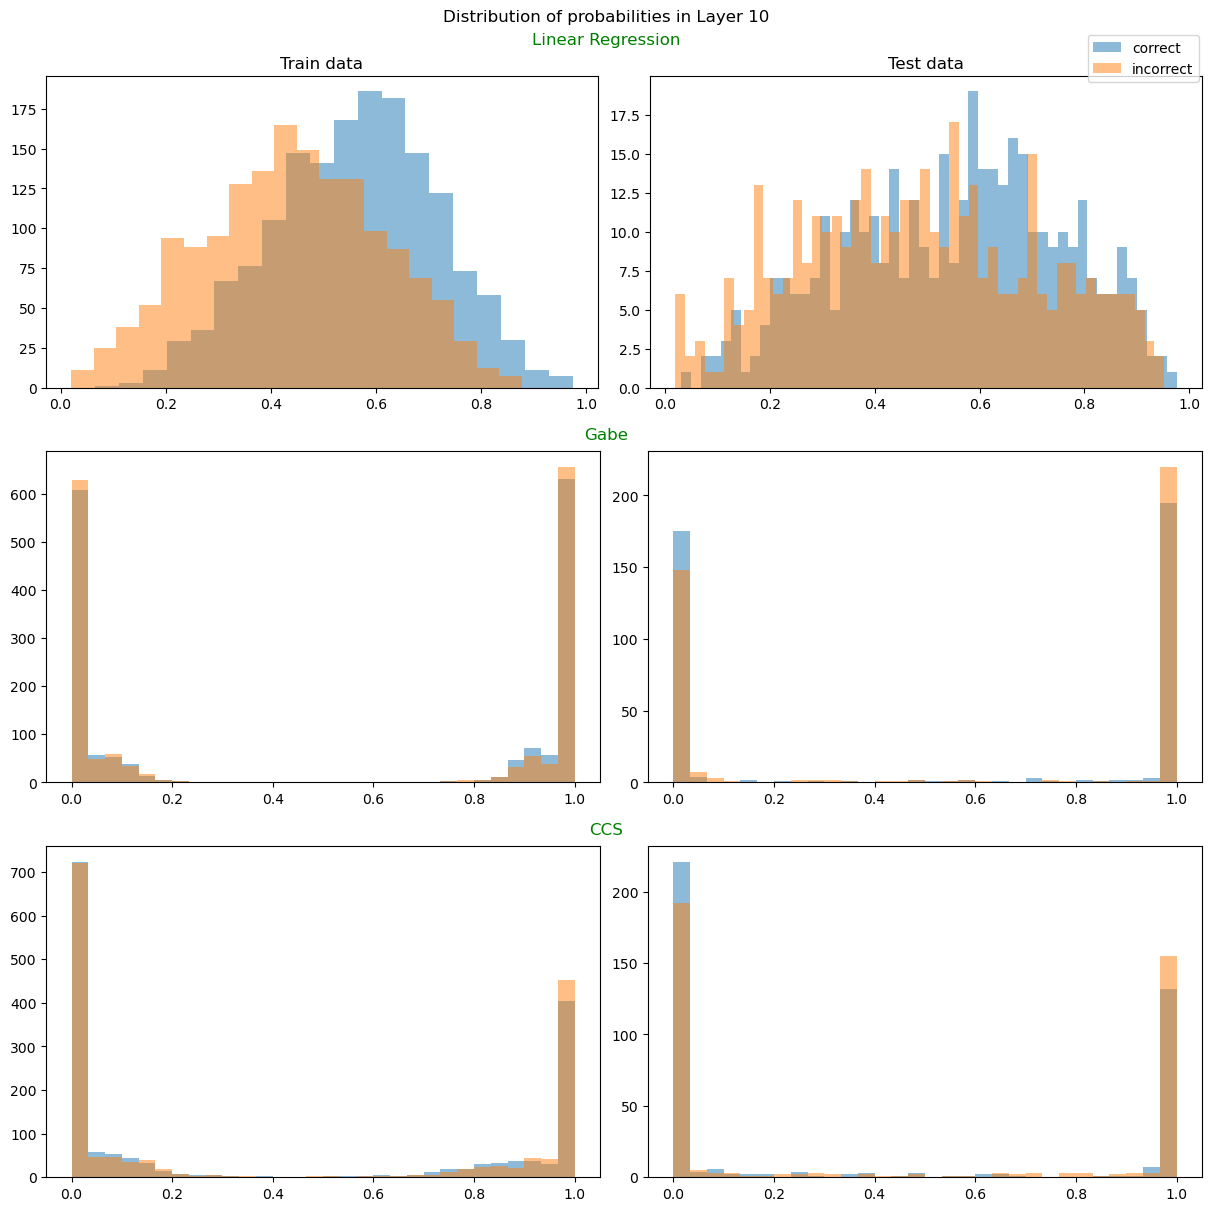

In [249]:
display_layer = 10


fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Distribution of probabilities in Layer {display_layer}")

subfigs = fig.subfigures(3, 1)

subfigs[0].suptitle("Linear Regression", color="green")
ax = subfigs[0].subplots(1, 2)
# histogram of outputs of lr_probes[display_layer] on train data
ax[0].hist(lr_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=20, alpha=.5, label="correct") # correct answers
ax[0].hist(lr_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=20, alpha=.5, label="incorrect") # incorrect answers
ax[0].set_title("Train data")
subfigs[0].legend()

# histogram of outputs of lr_probes[display_layer] on test data
ax[1].hist(lr_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=50, alpha=.5, label="correct") # correct answers
ax[1].hist(lr_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=50, alpha=.5, label="incorrect") # incorrect answers
ax[1].set_title("Test data")


subfigs[1].suptitle("Gabe", color="green")
ax = subfigs[1].subplots(1, 2)
# histogram of outputs of gabe_probes[display_layer] on train data
ax[0].hist(gabe_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="correct") # correct answers
ax[0].hist(gabe_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="incorrect") # incorrect answers

# histogram of outputs of gabe_probes[display_layer] on test data
ax[1].hist(gabe_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="correct") # correct answers
ax[1].hist(gabe_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="incorrect") # incorrect answers

subfigs[2].suptitle("CCS", color="green")
ax = subfigs[2].subplots(1, 2)
# histogram of outputs of ccs_probes[display_layer] on train data
ax[0].hist(ccs_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="correct") # correct answers
ax[0].hist(ccs_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="incorrect") # incorrect answers
# fig.legend()

# histogram of outputs of ccs_probes[display_layer] on test data
ax[1].hist(ccs_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="correct") # correct answers
ax[1].hist(ccs_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu(), bins=30, alpha=.5, label="incorrect") # incorrect answers

plt.show()



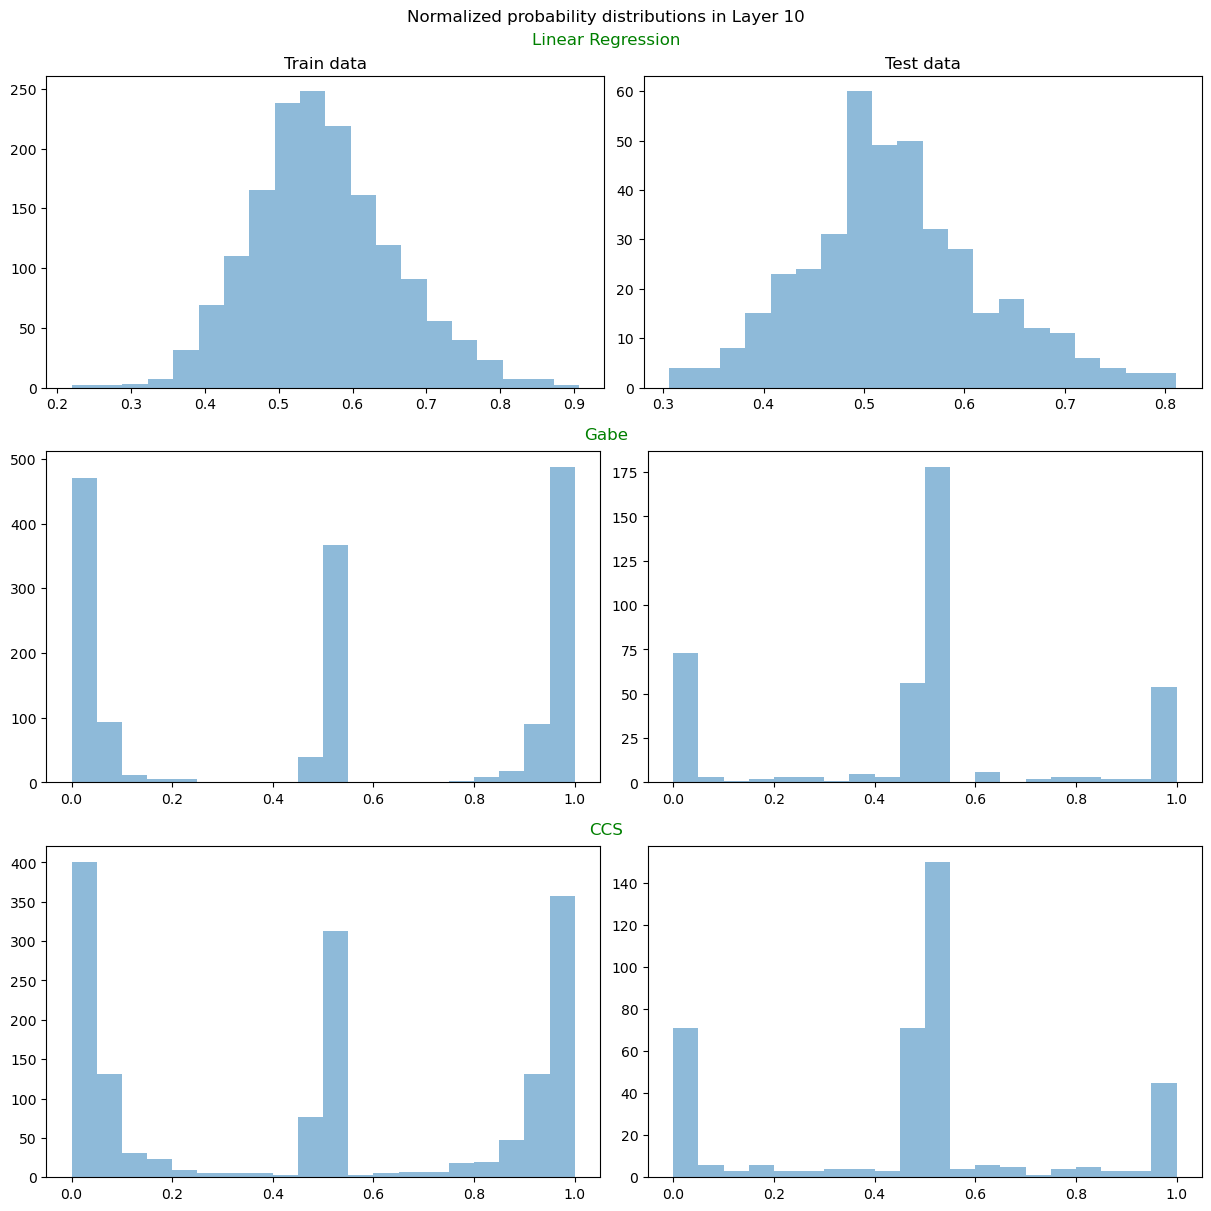

In [259]:
display_layer = 10


fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Normalized probability distributions in Layer {display_layer}")

subfigs = fig.subfigures(3, 1)

subfigs[0].suptitle("Linear Regression", color="green")
ax = subfigs[0].subplots(1, 2)
ax[0].hist((.5 * (lr_probes[display_layer](x_train[:,display_layer-1,0]) + 1-lr_probes[display_layer](x_train[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)
ax[0].set_title("Train data")

ax[1].hist((.5 * (lr_probes[display_layer](x_test[:,display_layer-1,0]) + 1-lr_probes[display_layer](x_test[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)
ax[1].set_title("Test data")

#Do the same for Gabe and CCS
subfigs[1].suptitle("Gabe", color="green")
ax = subfigs[1].subplots(1, 2)
ax[0].hist((.5 * (gabe_probes[display_layer](x_train[:,display_layer-1,0]) + 1-gabe_probes[display_layer](x_train[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)
ax[1].hist((.5 * (gabe_probes[display_layer](x_test[:,display_layer-1,0]) + 1-gabe_probes[display_layer](x_test[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)

subfigs[2].suptitle("CCS", color="green")
ax = subfigs[2].subplots(1, 2)
ax[0].hist((.5 * (ccs_probes[display_layer](x_train[:,display_layer-1,0]) + 1-ccs_probes[display_layer](x_train[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)
ax[1].hist((.5 * (ccs_probes[display_layer](x_test[:,display_layer-1,0]) + 1-ccs_probes[display_layer](x_test[:,display_layer-1,1]))).squeeze(-1).detach().cpu(), bins=20, alpha=.5)

plt.show()

# plt.scatter(lr_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
#             lr_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())


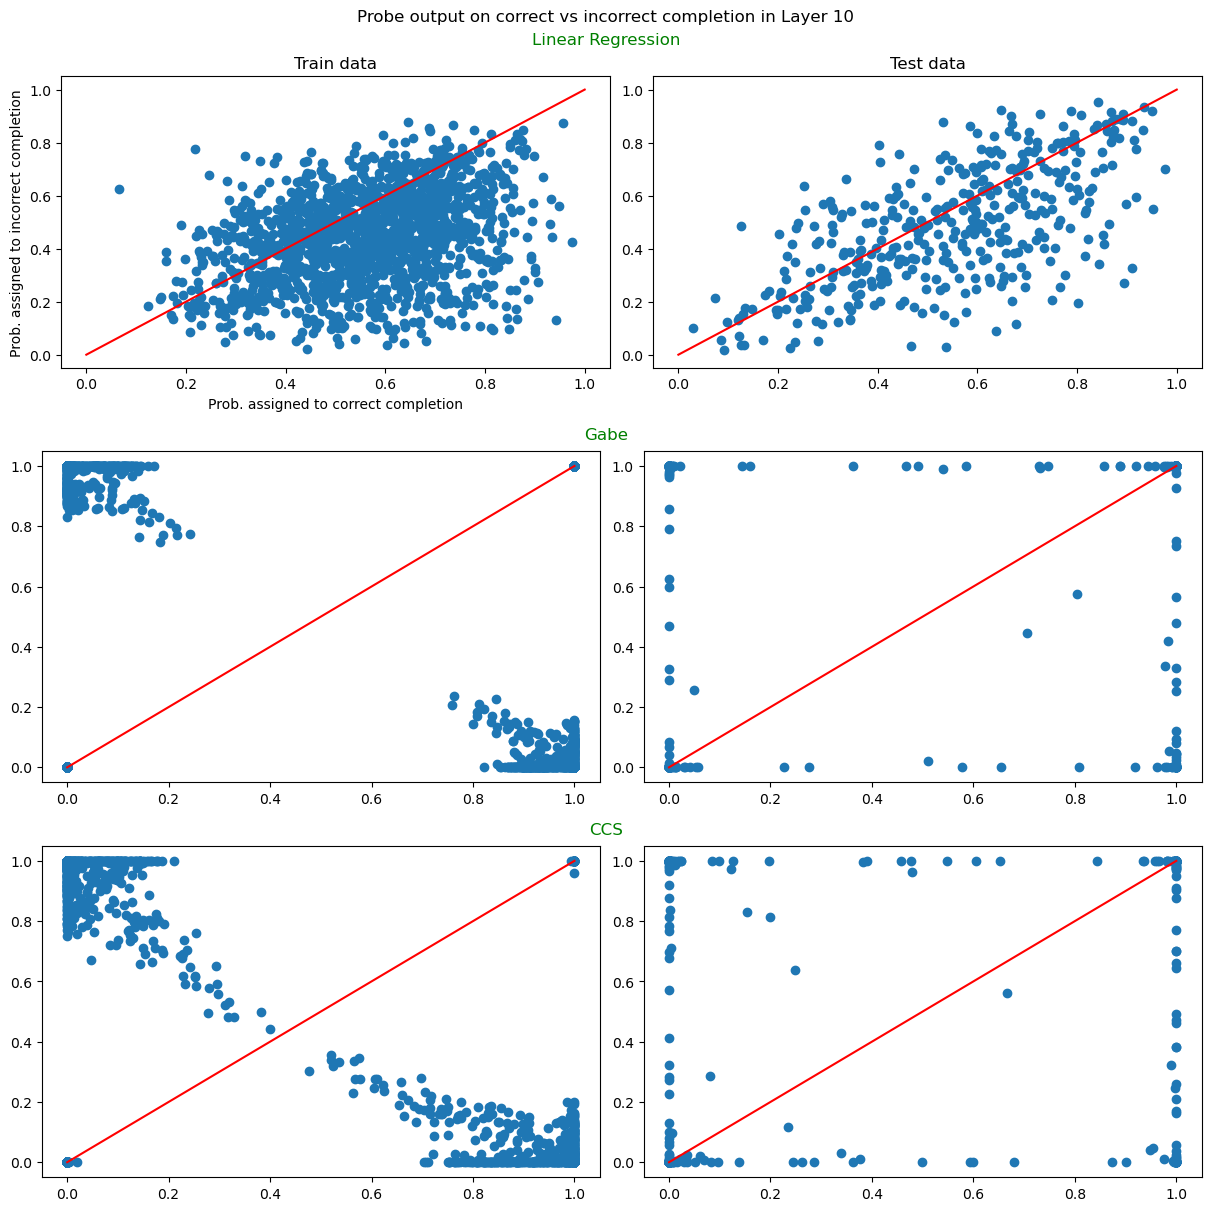

In [264]:
display_layer = 10

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Probe output on correct vs incorrect completion in Layer {display_layer}")

subfigs = fig.subfigures(3, 1)
subfigs[0].suptitle("Linear Regression", color="green")
ax = subfigs[0].subplots(1, 2)
ax[0].scatter(lr_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[0].set_title("Train data")
ax[0].set_xlabel("Prob. assigned to correct completion")
ax[0].set_ylabel("Prob. assigned to incorrect completion")

ax[1].scatter(lr_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].set_title("Test data")

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")


#Do the same for Gabe and CCS
subfigs[1].suptitle("Gabe", color="green")
ax = subfigs[1].subplots(1, 2)
ax[0].scatter(gabe_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].scatter(gabe_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")

subfigs[2].suptitle("CCS", color="green")
ax = subfigs[2].subplots(1, 2)
ax[0].scatter(ccs_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            ccs_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].scatter(ccs_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            ccs_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")

plt.show()


In [297]:
#How does accuracy change down as loss decreases?
epochs = 100000
layer = 11

train_loss_history = {}
test_loss_history = {}
train_acc_history = {}
test_acc_history = {}

#shuffle all_xs
shuffled_all_xs = all_xs[torch.randperm(all_xs.shape[0])]
x_train=shuffled_all_xs[:int(all_xs.shape[0]*.8)]
x_test=shuffled_all_xs[int(all_xs.shape[0]*.8):]

p = Probe().to(DEVICE)
optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = gabe_loss(x_train[:, layer-1, :num_classes], p)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        train_loss_history[i] = gabe_loss(x_train[:, layer-1, :num_classes], p).item()
        test_loss_history[i] = gabe_loss(x_test[:, layer-1, :num_classes], p).item()
        train_acc_history[i] = probe_acc(x_train[:, layer-1, :num_classes], p)
        test_acc_history[i] = probe_acc(x_test[:, layer-1, :num_classes], p)

        if i%2000 == 0:
            print(f"Epoch {i}: Train loss: {train_loss_history[i]}, Test loss: {test_loss_history[i]}, Train acc: {train_acc_history[i]}, Test acc: {test_acc_history[i]}")

  0%|          | 144/100000 [00:00<02:19, 714.84it/s]

Epoch 0: Train loss: 0.9388046264648438, Test loss: 0.9452275633811951, Train acc: 0.835625, Test acc: 0.8275


  2%|▏         | 2131/100000 [00:02<02:14, 726.34it/s]

Epoch 2000: Train loss: 0.721923828125, Test loss: 0.8579369187355042, Train acc: 0.724375, Test acc: 0.7225


  4%|▍         | 4110/100000 [00:05<02:14, 711.50it/s]

Epoch 4000: Train loss: 0.5911456942558289, Test loss: 0.7743949890136719, Train acc: 0.670625, Test acc: 0.6525


  6%|▌         | 6097/100000 [00:08<02:07, 736.51it/s]

Epoch 6000: Train loss: 0.4813930094242096, Test loss: 0.694183349609375, Train acc: 0.620625, Test acc: 0.6125


  8%|▊         | 8081/100000 [00:11<02:07, 723.46it/s]

Epoch 8000: Train loss: 0.4215210974216461, Test loss: 0.6319141983985901, Train acc: 0.60375, Test acc: 0.5725


 10%|█         | 10083/100000 [00:13<02:02, 735.09it/s]

Epoch 10000: Train loss: 0.3906320035457611, Test loss: 0.6431950330734253, Train acc: 0.601875, Test acc: 0.585


 12%|█▏        | 12128/100000 [00:16<02:02, 715.72it/s]

Epoch 12000: Train loss: 0.37338775396347046, Test loss: 0.6384572386741638, Train acc: 0.595625, Test acc: 0.59


 14%|█▍        | 14090/100000 [00:19<01:58, 723.68it/s]

Epoch 14000: Train loss: 0.36340758204460144, Test loss: 0.6431459188461304, Train acc: 0.6025, Test acc: 0.6075


 16%|█▌        | 16128/100000 [00:22<01:57, 715.83it/s]

Epoch 16000: Train loss: 0.35568541288375854, Test loss: 0.6458917856216431, Train acc: 0.606875, Test acc: 0.605


 18%|█▊        | 18106/100000 [00:24<01:51, 734.84it/s]

Epoch 18000: Train loss: 0.3462538719177246, Test loss: 0.6503364443778992, Train acc: 0.6075, Test acc: 0.6025


 20%|██        | 20096/100000 [00:27<01:49, 727.70it/s]

Epoch 20000: Train loss: 0.3421960771083832, Test loss: 0.6559914946556091, Train acc: 0.61625, Test acc: 0.6025


 22%|██▏       | 22088/100000 [00:30<01:45, 741.53it/s]

Epoch 22000: Train loss: 0.33919844031333923, Test loss: 0.6591252088546753, Train acc: 0.6175, Test acc: 0.6075


 24%|██▍       | 24092/100000 [00:33<01:42, 738.41it/s]

Epoch 24000: Train loss: 0.3358602821826935, Test loss: 0.6595974564552307, Train acc: 0.62125, Test acc: 0.62


 26%|██▌       | 26112/100000 [00:35<01:41, 729.59it/s]

Epoch 26000: Train loss: 0.3327633738517761, Test loss: 0.6630463004112244, Train acc: 0.620625, Test acc: 0.62


 28%|██▊       | 28082/100000 [00:38<01:39, 720.71it/s]

Epoch 28000: Train loss: 0.3312801420688629, Test loss: 0.6634150743484497, Train acc: 0.625, Test acc: 0.625


 30%|███       | 30093/100000 [00:41<01:35, 733.45it/s]

Epoch 30000: Train loss: 0.32737478613853455, Test loss: 0.6642715930938721, Train acc: 0.625625, Test acc: 0.625


 32%|███▏      | 32132/100000 [00:44<01:32, 734.78it/s]

Epoch 32000: Train loss: 0.32659652829170227, Test loss: 0.6633185148239136, Train acc: 0.62875, Test acc: 0.6275


 34%|███▍      | 34119/100000 [00:46<01:32, 715.20it/s]

Epoch 34000: Train loss: 0.3260904550552368, Test loss: 0.6633009314537048, Train acc: 0.63125, Test acc: 0.6325


 36%|███▌      | 36124/100000 [00:49<01:26, 737.93it/s]

Epoch 36000: Train loss: 0.3256901800632477, Test loss: 0.6635545492172241, Train acc: 0.633125, Test acc: 0.6375


 38%|███▊      | 38121/100000 [00:52<01:24, 730.66it/s]

Epoch 38000: Train loss: 0.32536619901657104, Test loss: 0.6638687252998352, Train acc: 0.635, Test acc: 0.6475


 40%|████      | 40107/100000 [00:55<01:21, 733.34it/s]

Epoch 40000: Train loss: 0.3251001536846161, Test loss: 0.6641786098480225, Train acc: 0.63625, Test acc: 0.645


 42%|████▏     | 42113/100000 [00:57<01:19, 727.48it/s]

Epoch 42000: Train loss: 0.3248804807662964, Test loss: 0.6645011901855469, Train acc: 0.6375, Test acc: 0.65


 44%|████▍     | 44101/100000 [01:00<01:16, 727.56it/s]

Epoch 44000: Train loss: 0.3242044448852539, Test loss: 0.6653730869293213, Train acc: 0.63875, Test acc: 0.6475


 46%|████▌     | 46121/100000 [01:03<01:12, 739.17it/s]

Epoch 46000: Train loss: 0.32276657223701477, Test loss: 0.6646860837936401, Train acc: 0.64, Test acc: 0.645


 48%|████▊     | 48100/100000 [01:06<01:15, 686.17it/s]

Epoch 48000: Train loss: 0.32201793789863586, Test loss: 0.6651255488395691, Train acc: 0.64, Test acc: 0.6525


 50%|█████     | 50101/100000 [01:09<01:13, 678.62it/s]

Epoch 50000: Train loss: 0.3219000995159149, Test loss: 0.6655567288398743, Train acc: 0.64125, Test acc: 0.6525


 52%|█████▏    | 52087/100000 [01:11<01:04, 742.87it/s]

Epoch 52000: Train loss: 0.32179710268974304, Test loss: 0.665751039981842, Train acc: 0.641875, Test acc: 0.655


 54%|█████▍    | 54096/100000 [01:14<01:02, 738.38it/s]

Epoch 54000: Train loss: 0.3217105269432068, Test loss: 0.6659075617790222, Train acc: 0.641875, Test acc: 0.655


 56%|█████▌    | 56147/100000 [01:17<01:00, 726.79it/s]

Epoch 56000: Train loss: 0.3216378688812256, Test loss: 0.6660789251327515, Train acc: 0.644375, Test acc: 0.655


 58%|█████▊    | 58072/100000 [01:20<00:59, 704.17it/s]

Epoch 58000: Train loss: 0.32157719135284424, Test loss: 0.6662638187408447, Train acc: 0.645625, Test acc: 0.655


 60%|██████    | 60125/100000 [01:22<00:54, 733.38it/s]

Epoch 60000: Train loss: 0.3215261399745941, Test loss: 0.6664722561836243, Train acc: 0.645625, Test acc: 0.655


 62%|██████▏   | 62070/100000 [01:25<00:55, 681.30it/s]

Epoch 62000: Train loss: 0.32148322463035583, Test loss: 0.6666153073310852, Train acc: 0.64625, Test acc: 0.6575


 64%|██████▍   | 64136/100000 [01:28<00:52, 680.53it/s]

Epoch 64000: Train loss: 0.3214469850063324, Test loss: 0.666846752166748, Train acc: 0.64625, Test acc: 0.6575


 66%|██████▌   | 66105/100000 [01:31<00:46, 729.30it/s]

Epoch 66000: Train loss: 0.32141655683517456, Test loss: 0.6670355200767517, Train acc: 0.64625, Test acc: 0.6575


 68%|██████▊   | 68088/100000 [01:34<00:43, 735.56it/s]

Epoch 68000: Train loss: 0.3213908076286316, Test loss: 0.6672473549842834, Train acc: 0.646875, Test acc: 0.66


 70%|███████   | 70143/100000 [01:36<00:41, 722.75it/s]

Epoch 70000: Train loss: 0.32136911153793335, Test loss: 0.667410671710968, Train acc: 0.6475, Test acc: 0.6625


 72%|███████▏  | 72129/100000 [01:39<00:37, 733.49it/s]

Epoch 72000: Train loss: 0.3213508427143097, Test loss: 0.6675897240638733, Train acc: 0.6475, Test acc: 0.665


 74%|███████▍  | 74107/100000 [01:42<00:35, 722.92it/s]

Epoch 74000: Train loss: 0.3213353753089905, Test loss: 0.6677597761154175, Train acc: 0.648125, Test acc: 0.6675


 76%|███████▌  | 76104/100000 [01:45<00:32, 740.11it/s]

Epoch 76000: Train loss: 0.3213222920894623, Test loss: 0.667955756187439, Train acc: 0.64875, Test acc: 0.6675


 78%|███████▊  | 78102/100000 [01:47<00:29, 740.71it/s]

Epoch 78000: Train loss: 0.32131120562553406, Test loss: 0.6680954694747925, Train acc: 0.649375, Test acc: 0.6675


 80%|████████  | 80117/100000 [01:50<00:27, 729.65it/s]

Epoch 80000: Train loss: 0.3213018774986267, Test loss: 0.6682668924331665, Train acc: 0.650625, Test acc: 0.67


 82%|████████▏ | 82127/100000 [01:53<00:24, 727.82it/s]

Epoch 82000: Train loss: 0.3212939500808716, Test loss: 0.6684603691101074, Train acc: 0.651875, Test acc: 0.67


 84%|████████▍ | 84113/100000 [01:56<00:21, 723.42it/s]

Epoch 84000: Train loss: 0.32128727436065674, Test loss: 0.6686570048332214, Train acc: 0.65125, Test acc: 0.67


 86%|████████▌ | 86089/100000 [01:58<00:19, 725.17it/s]

Epoch 86000: Train loss: 0.3212815821170807, Test loss: 0.6688143610954285, Train acc: 0.651875, Test acc: 0.67


 88%|████████▊ | 88084/100000 [02:01<00:16, 727.22it/s]

Epoch 88000: Train loss: 0.32127678394317627, Test loss: 0.6690281629562378, Train acc: 0.651875, Test acc: 0.6775


 90%|█████████ | 90087/100000 [02:04<00:13, 741.35it/s]

Epoch 90000: Train loss: 0.32127270102500916, Test loss: 0.6692367196083069, Train acc: 0.651875, Test acc: 0.6775


 92%|█████████▏| 92109/100000 [02:06<00:10, 740.93it/s]

Epoch 92000: Train loss: 0.3212692439556122, Test loss: 0.6694546341896057, Train acc: 0.6525, Test acc: 0.68


 94%|█████████▍| 94129/100000 [02:09<00:07, 736.47it/s]

Epoch 94000: Train loss: 0.3212663531303406, Test loss: 0.6696757078170776, Train acc: 0.653125, Test acc: 0.685


 96%|█████████▌| 96121/100000 [02:12<00:05, 723.93it/s]

Epoch 96000: Train loss: 0.3212638795375824, Test loss: 0.6698737740516663, Train acc: 0.653125, Test acc: 0.685


 98%|█████████▊| 98117/100000 [02:15<00:02, 736.53it/s]

Epoch 98000: Train loss: 0.32126179337501526, Test loss: 0.6699800491333008, Train acc: 0.65375, Test acc: 0.685


100%|██████████| 100000/100000 [02:17<00:00, 725.79it/s]


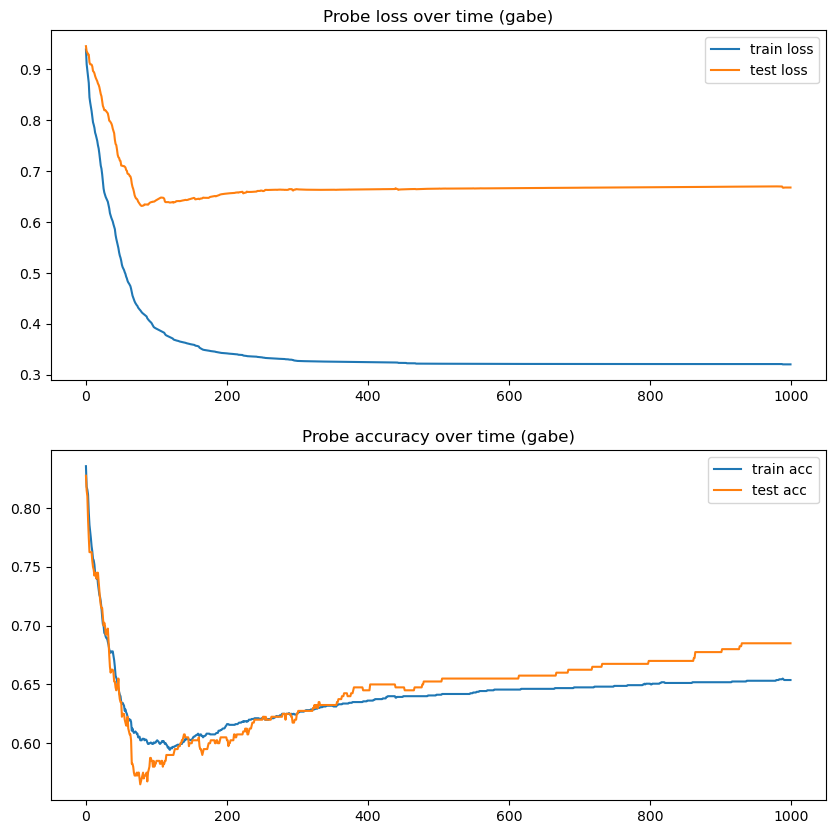

In [298]:
# plot both losses and accuracies on same graph
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot([train_loss_history[i] for i in range(0,epochs,100)], label=f'train loss')
plt.plot([test_loss_history[i] for i in range(0,epochs,100)], label=f'test loss')
plt.title("Probe loss over time (gabe)")
plt.legend()

plt.subplot(2,1,2)
plt.plot([train_acc_history[i] for i in range(0,epochs,100)], label=f'train acc')
plt.plot([test_acc_history[i] for i in range(0,epochs,100)], label=f'test acc')
plt.title("Probe accuracy over time (gabe)")
plt.legend()
plt.show()

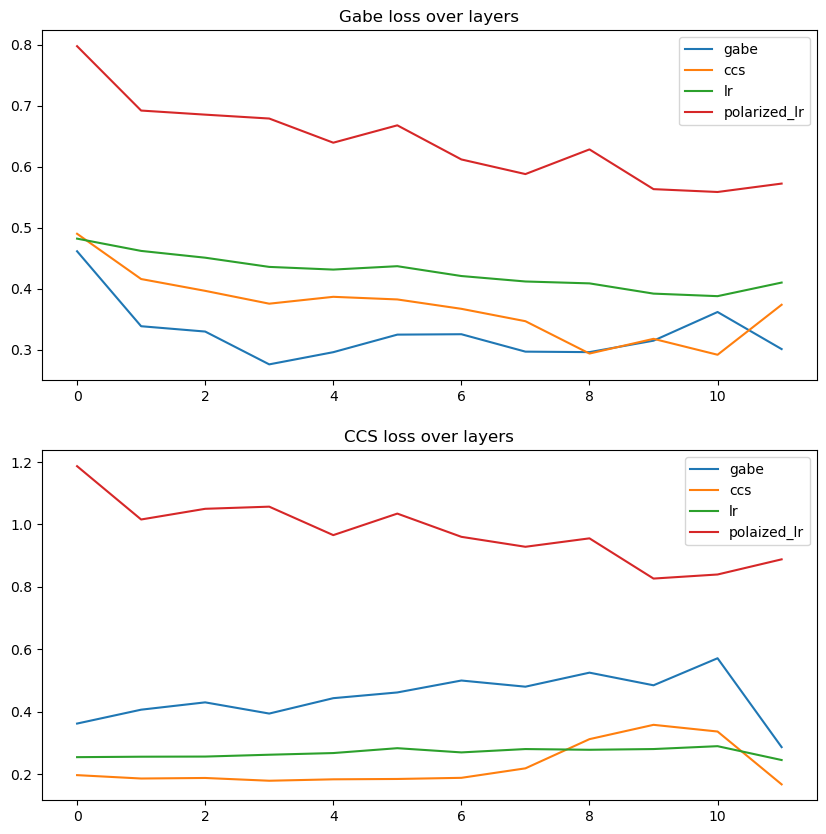

In [332]:
polarized_lr_probes = {}
POLARIZATION = 100
for (key, probe) in lr_probes.items():
    p = Probe()
    p.probe.weight.data = probe.probe.weight.data * POLARIZATION
    p.probe.bias.data = probe.probe.bias.data * POLARIZATION
    polarized_lr_probes[key] = p

# put both of the above plots on the same plt object using subplots
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot([gabe_loss(x_test[:, layer-1, :num_classes], gabe_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'gabe')
axs[0].plot([gabe_loss(x_test[:, layer-1, :num_classes], ccs_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'ccs')
axs[0].plot([gabe_loss(x_test[:, layer-1, :num_classes], lr_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'lr')
axs[0].plot([gabe_loss(x_test[:, layer-1, :num_classes], polarized_lr_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'polarized_lr')
axs[0].set_title("Gabe loss over layers")
axs[0].legend()
axs[1].plot([ccs_loss(x_test[:, layer-1, :num_classes], gabe_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'gabe')
axs[1].plot([ccs_loss(x_test[:, layer-1, :num_classes], ccs_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'ccs')
axs[1].plot([ccs_loss(x_test[:, layer-1, :num_classes], lr_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'lr')
axs[1].plot([ccs_loss(x_test[:, layer-1, :num_classes], polarized_lr_probes[layer]).detach().cpu() for layer in range(1, 13)], label=f'polarized_lr')
axs[1].set_title("CCS loss over layers")
axs[1].legend()
plt.show()